# Rock Paper Scissors - AI
## Model training

### Imports

In [1]:
#lib imports
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#local imports
from utils import *
from plotting import *
from model_creator import *
from image_processing import random_color_and_grayscale_augmentation

print('TensorFlow version: ', tf.__version__)
print('Keras version: ', keras.__version__)
print('Python version: ', os.sys.version)

TensorFlow version:  2.16.1
Keras version:  3.1.1
Python version:  3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:42:31) [MSC v.1937 64 bit (AMD64)]


### Dataset preprocessing

In [2]:
local_dir = './'
original_data_dir = os.path.join(local_dir, 'src_data')
# src_data contains the original data from the Kaggle dataset together with the augmented data from 'resized_images'
dataset_dir = os.path.join(local_dir, 'dataset')
models_dir = os.path.join(local_dir, 'models')

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

if not os.path.exists(original_data_dir):
    raise FileNotFoundError('Original data directory not found')

classes = ['rock', 'paper', 'scissors']

if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)
    split_dataset(classes, original_data_dir, dataset_dir)

for path in [train_dir, val_dir, test_dir]:
    if not os.path.exists(path):
        raise FileNotFoundError(f'{path} not found')
    
    print(path)
    for class_name in classes:
        print(f'    - {class_name}: {len(os.listdir(os.path.join(path, class_name)))} images')
  

./dataset\train
    - rock: 1511 images
    - paper: 1527 images
    - scissors: 1544 images
./dataset\val
    - rock: 189 images
    - paper: 191 images
    - scissors: 193 images
./dataset\test
    - rock: 189 images
    - paper: 191 images
    - scissors: 193 images


In [3]:
check_for_duplicates_in_dataset('./dataset')

No duplicates found in dataset
5728 files found in dataset


### Data augmentation

Found 4582 images belonging to 3 classes.
Found 573 images belonging to 3 classes.
Found 573 images belonging to 3 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


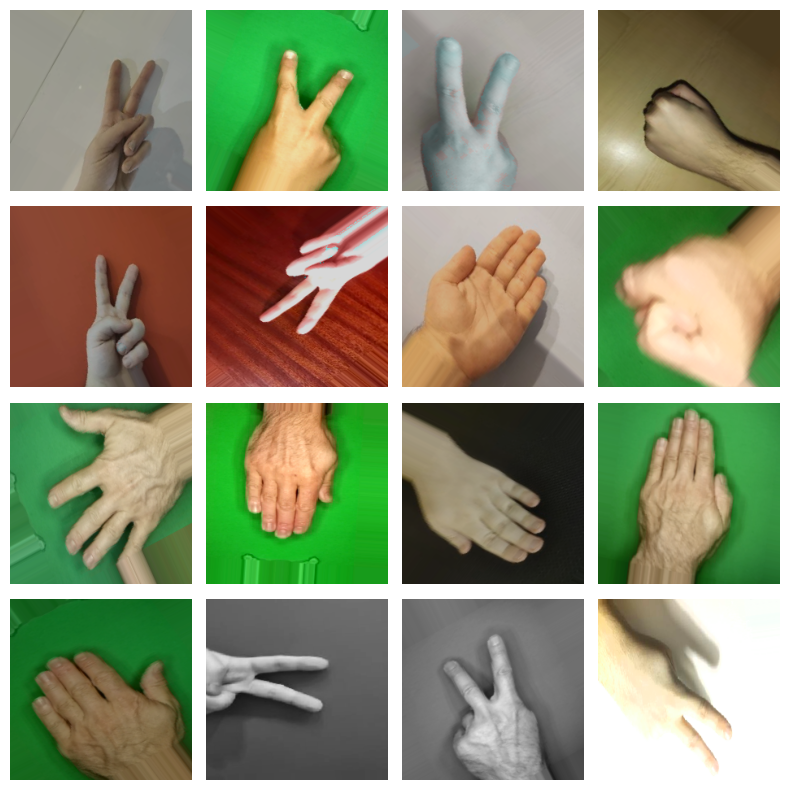

In [4]:
# Image target size
img_rows, img_cols = 224, 224

# Data augmentation and normalization for training
'''
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    channel_shift_range=150,
    preprocessing_function=random_color_and_grayscale_augmentation)
'''
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    vertical_flip=True,
    brightness_range=[0.7, 1.4],
    preprocessing_function=random_color_and_grayscale_augmentation)


test_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_rows, img_cols),
    batch_size=32,
    class_mode='categorical')

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_rows, img_cols),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_rows, img_cols),
    batch_size=32,
    class_mode='categorical')

plot_grid_from_generator(train_generator, 4, 4)

### Model CNN

### Training

In [5]:
EPOCHS = 1
MODEL_NAME = 'cnn_lower_l2_less_augmentation'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(models_dir, f'{MODEL_NAME}_ckp.keras'),
    save_weights_only=False,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

csvlogger_callback = tf.keras.callbacks.CSVLogger(
    filename=os.path.join(models_dir, f'{MODEL_NAME}_ckp_history.csv'),     
    separator=',',                      
    append=True                           
)

hist_dict = compile_and_train_model(
    create_model_func=build_regularized_cnn_l2_0001,
    create_model_args={'input_shape' : (224, 224, 3), 'num_classes' :3},
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['acc'], 
    train_generator=train_generator,
    val_generator=val_generator,
    epochs=EPOCHS,
    models_dir=models_dir,
    model_name=MODEL_NAME,
    callbacks=[checkpoint_callback, csvlogger_callback]
)


c:\Users\adria\anaconda3\envs\ML\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
c:\Users\adria\anaconda3\envs\ML\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


144/144 ━━━━━━━━━━━━━━━━━━━━ 138s 934ms/step - acc: 0.4853 - loss: 1.5081 - val_acc: 0.3298 - val_loss: 2.6807
Model saved in ./models\cnn_lower_l2_less_augmentation.keras
History saved in ./models\cnn_lower_l2_less_augmentation_history.csv


<Figure size 640x480 with 0 Axes>

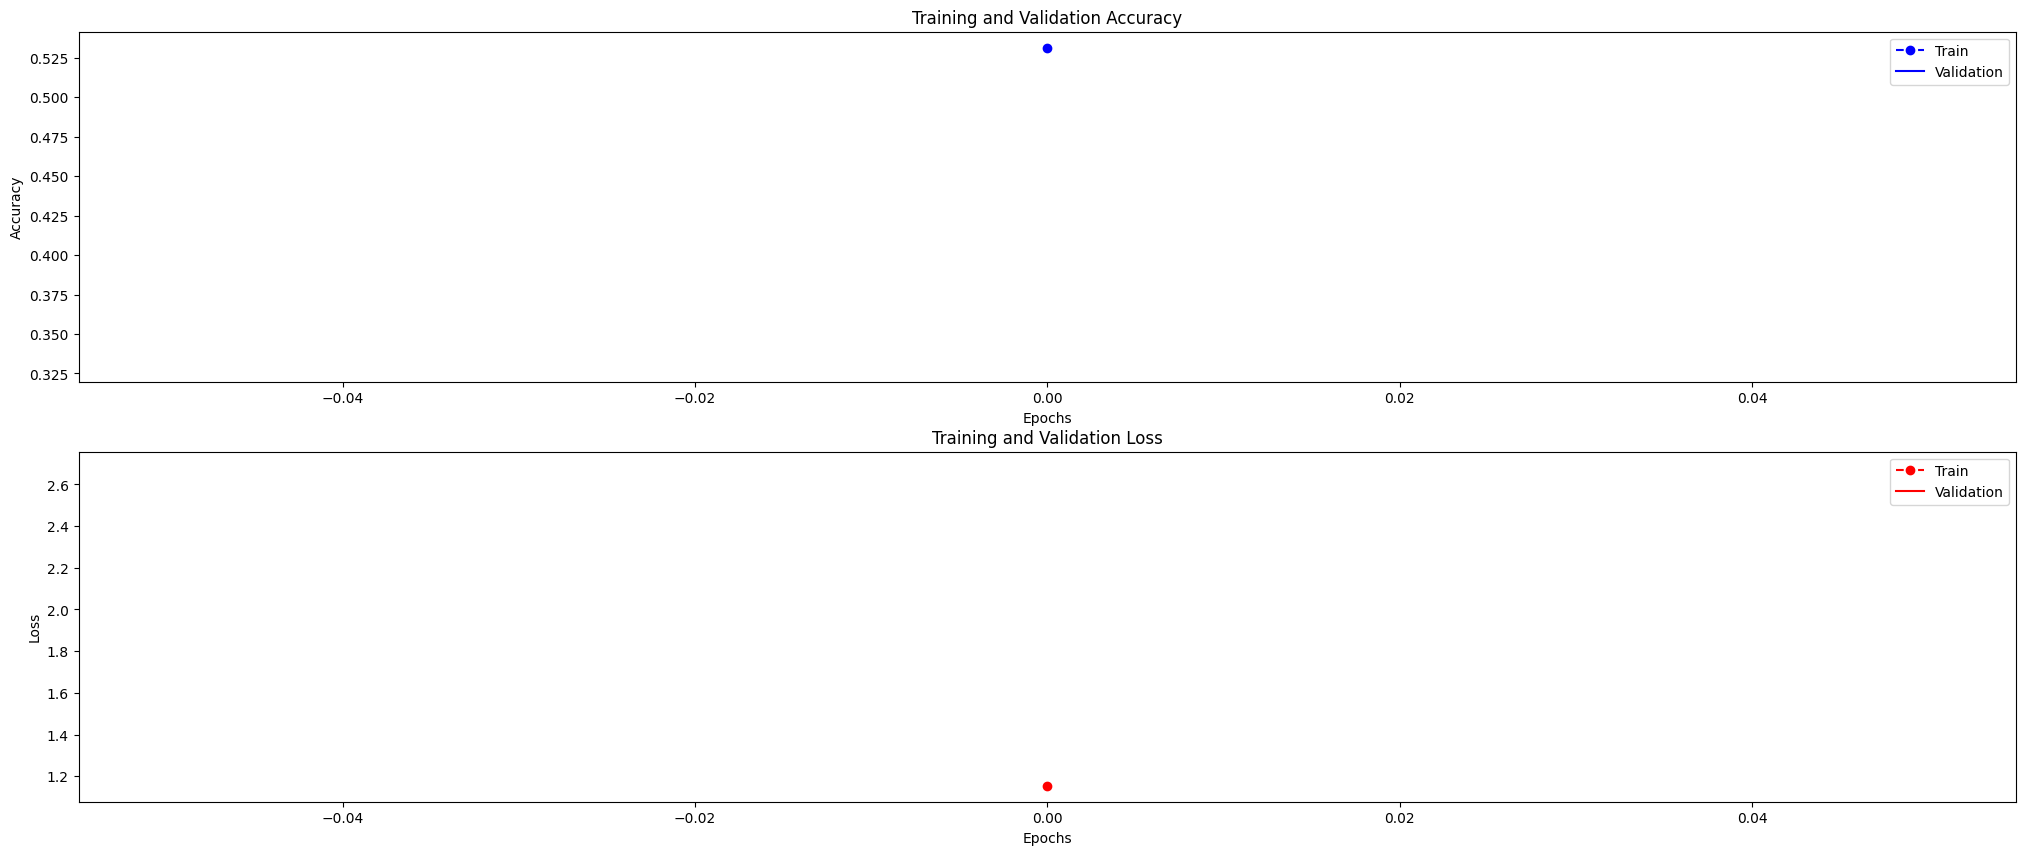

In [6]:
plot_accuracy_and_loss(hist_dict)